[Github link as required](https://github.com/victormcneill/Graphs-and-Network-systems)

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community import louvain_communities, modularity


# Graph Based Movie Recomendation Algorithm

## Introduction

This report will outline a graph based, genre specific movie recommendation algorithm using the MovieLens 32m dataset. Weighted edges, derived from a modelled influence and similarity, are used to connect user and movie nodes. From this a shortest path algorithm will generate a personalised recomendation based on the movie that will be most likely enjoyed.

The MovieLens dataset contains 32 million ratings between 200,948 users and 87,585 movies. This would result in a very large graph if modelled with all users and movies, leading to analysis of this graph being very computationally expensive. Each User will have genre specific taste so treating all movies equally would dilute results. Focusing this graph to be genre specific will ensure relevant influence and similarity patters and subsampling to 2000 movies will keep the computations manageable.

In [4]:
ratings = pd.read_csv(r'ml-32m\ratings.csv')
movies = pd.read_csv(r'ml-32m\movies.csv')

# Split genres and explode
movies['genres'] = movies['genres'].str.split('|')
movies_exploded = movies.explode('genres')

# Merge ratings with genres
ratings_genres = ratings.merge(movies_exploded, on='movieId')

# Count ratings per genre
genre_counts = ratings_genres.groupby('genres')['rating'].count().sort_values()
print("Number of ratings per genre:\n", genre_counts)

# Pick a genre with fewer ratings
chosen_genre = genre_counts.index[2]  # the genre with the third fewest ratings
ratings_genre = ratings_genres[ratings_genres['genres'] == chosen_genre]

# Count unique movies in that genre
num_movies = ratings_genre['movieId'].nunique()
num_users = ratings_genre['userId'].nunique()
num_ratings = ratings_genre.shape[0]

print(f"Chosen genre: {chosen_genre}")
print(f"Number of movies in this genre: {num_movies}")
print(f"Number of users in this genre: {num_users}")
print(f"Number of ratings in this genre: {num_ratings}")

Number of ratings per genre:
 genres
(no genres listed)       55498
Film-Noir               304710
Documentary             427353
Western                 596654
Musical                1159516
IMAX                   1494179
War                    1594110
Animation              2214562
Horror                 2492315
Mystery                2615322
Children               2731841
Fantasy                3702759
Crime                  5373051
Romance                5524615
Sci-Fi                 5717337
Adventure              7590522
Thriller               8679464
Action                 9665213
Comedy                11206926
Drama                 13973271
Name: rating, dtype: int64
Chosen genre: Documentary
Number of movies in this genre: 9103
Number of users in this genre: 74356
Number of ratings in this genre: 427353


In [5]:

# Filter documentaries
documentaries = movies[movies['genres'].str.contains('Documentary', regex=False)]
sampled_movie_ids = documentaries['movieId'].tolist()

documentary_ratings = ratings[ratings['movieId'].isin(sampled_movie_ids)]
user_rating_counts = documentary_ratings.groupby('userId').size()

# Keep only users who have rated more than 1 movie
active_users = user_rating_counts[user_rating_counts > 1].index.tolist()

filtered_ratings = documentary_ratings[documentary_ratings['userId'].isin(active_users)]

# Check the numbers
num_active_users = len(active_users)
num_filtered_ratings = len(filtered_ratings)
print(f"Number of users who rated more than 1 documentary: {num_active_users}")
print(f"Number of ratings after filtering: {num_filtered_ratings}")


Number of users who rated more than 1 documentary: 43899
Number of ratings after filtering: 396896


## Methods

To model user influence, a complete graph is created where each node is a user. The Edges weights are higher when a rating leads to many later ratings, especially if the latter rating matches the initial rating. A temporal decay factor is applied so recent influence counts more as users who previously influenced others may longer do so, and for a recommendation algorithm, the current taste of the users is far more important. For this example movie with id 37 was chosen. This movie has been rated by 85 users so the graph will have 85 user nodes and 3570 edges as the numbver of edges in a complete graph is calculated with the formula

$E = \frac{N(N-1)}{2}$,

where $E$ is the number of edges and $N$ is the number of nodes.

This is a complete graph so the maximum and average degree will be 84 as all nodes have edges to all other nodes.

Randomly selected users: [90397, 179123, 185683, 1474, 106219]


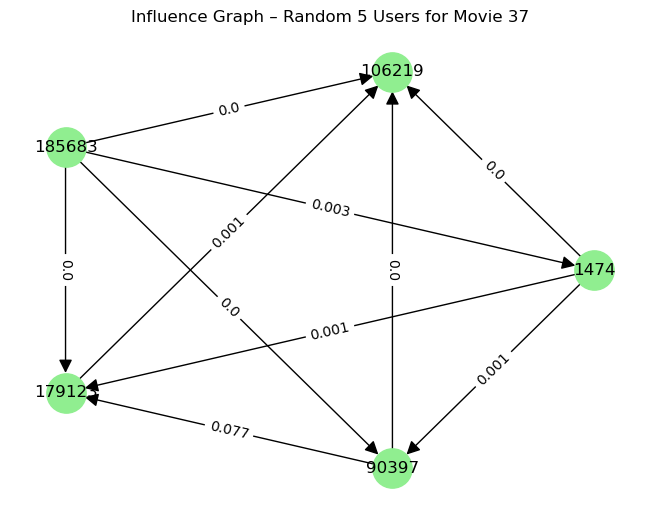

In [6]:
movie_id = 37
movie_ratings = filtered_ratings[filtered_ratings['movieId'] == movie_id].sort_values('timestamp')
movie_ratings['timestamp_days'] = (movie_ratings['timestamp'] - movie_ratings['timestamp'].min()) / (60*60*24)

# create user-user influence graph
G = nx.DiGraph()
users = movie_ratings['userId'].tolist()
G.add_nodes_from(users)

for i in range(len(movie_ratings)):
    u_i, r_i, t_i = movie_ratings.iloc[i]['userId'], movie_ratings.iloc[i]['rating'], movie_ratings.iloc[i]['timestamp_days']
    for j in range(i+1, len(movie_ratings)):
        u_j, r_j, t_j = movie_ratings.iloc[j]['userId'], movie_ratings.iloc[j]['rating'], movie_ratings.iloc[j]['timestamp_days']
        delta_t = t_j - t_i

        diff_rating = 1 - abs(r_i - r_j)/4           # normalized rating difference (0-1)
        influence = diff_rating * (0.995 ** delta_t)

        G.add_edge(u_i, u_j, weight=influence)


# find average influence per user (out-degree weighted average)
avg_influence = {}
for u in G.nodes:
    out_edges = G.out_edges(u, data=True)
    if len(out_edges) > 0:
        avg_influence[u] = sum([d['weight'] for _,_,d in out_edges]) / len(out_edges)
    else:
        avg_influence[u] = 0

random.seed(0)
random_users = random.sample(list(movie_ratings['userId'].unique()), 5)
print(f"Randomly selected users: {random_users}")

# plot the subgraph
H = G.subgraph(random_users).copy()

if H.number_of_edges() > 0:
    pos = nx.circular_layout(H)
    edge_labels = nx.get_edge_attributes(H, 'weight')
    nx.draw(H, pos, with_labels=True, node_color='lightgreen', node_size=800, arrowsize=20)
    nx.draw_networkx_edge_labels(H, pos, edge_labels={k: round(v,3) for k,v in edge_labels.items()})
    plt.title(f"Influence Graph – Random 5 Users for Movie {movie_id}")
    plt.show()
else:
    print("No edges to plot among these users — influence may still be too low. Try adjusting decay or similarity scaling.")


Top 5 most influential users: [173184, 85811, 149429, 154541, 154996]


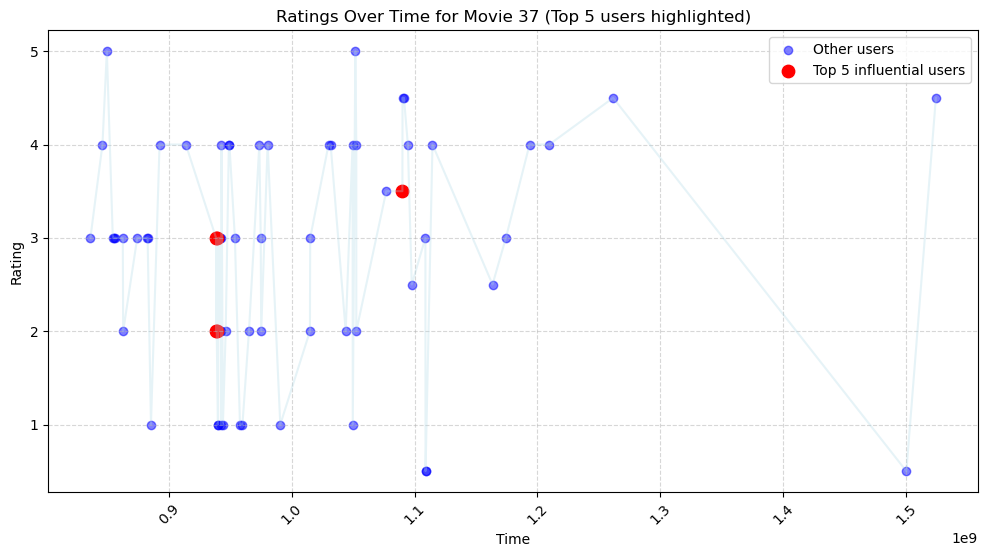

In [7]:
# find average influence
avg_influence = {}
for u in G.nodes:
    out_edges = G.out_edges(u, data=True)
    if len(out_edges) > 0:
        avg_influence[u] = sum([d['weight'] for _,_,d in out_edges]) / len(out_edges)
    else:
        avg_influence[u] = 0
movie_ratings['avg_influence'] = movie_ratings['userId'].map(avg_influence)

# extract top 5 influential 
top_users = sorted(avg_influence, key=avg_influence.get, reverse=True)[:5]
print(f"Top 5 most influential users: {top_users}")

top_ratings = movie_ratings[movie_ratings['userId'].isin(top_users)]
other_ratings = movie_ratings[~movie_ratings['userId'].isin(top_users)]

# plot
plt.figure(figsize=(12,6))
plt.scatter(other_ratings['timestamp'], other_ratings['rating'], 
            color='blue', alpha=0.5, label='Other users')
plt.scatter(top_ratings['timestamp'], top_ratings['rating'], 
            color='red', s=80, label='Top 5 influential users')
plt.plot(movie_ratings['timestamp'], movie_ratings['rating'], color='lightblue', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Rating')
plt.title(f'Ratings Over Time for Movie {movie_id} (Top 5 users highlighted)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


To model Movie similarity, a complete graph is created where each node is a movie. To calculate similarity, cosine similarity is used to find the weights of the edges connecting these movies. In this case cosine similarity will be calculated by taking all users who rated both movies, treat their ratings as vectors and then compute the angle between those vectors.

$\text{sim}(m_1, m_2) =
\frac{
\sum_{u \in U_{m_1,m_2}} r_{u,m_1} \cdot r_{u,m_2}
}{
\sqrt{\sum_{u \in U_{m_1,m_2}} r_{u,m_1}^2} \;\;
\sqrt{\sum_{u \in U_{m_1,m_2}} r_{u,m_2}^2}
}$,

where $r_{u,m}$ is the rating of user $u$ for movie $m$ and $U_{m_1,m_2}$ is users who rated both movies.

This is a complete graph so the maximum and average degree will be 84 as all nodes have edges to all other nodes.

In [8]:
# Pick 2 random movies
sampled_movies = filtered_ratings['movieId'].drop_duplicates().sample(2, random_state=3).values
movie1_id, movie2_id = sampled_movies
print(f"Comparing movies {movie1_id} and {movie2_id}")

# Get ratings for users who rated BOTH movies
ratings1 = filtered_ratings[filtered_ratings['movieId'] == movie1_id][['userId', 'rating']]
ratings2 = filtered_ratings[filtered_ratings['movieId'] == movie2_id][['userId', 'rating']]

# Merge on userId to keep only overlapping users
merged = pd.merge(ratings1, ratings2, on='userId', suffixes=('_1', '_2'))

# If there are no overlapping users, similarity cannot be computed
if len(merged) == 0:
    print("No users rated both movies. Similarity cannot be computed.")
else:
    r1 = merged['rating_1'].values
    r2 = merged['rating_2'].values

    # Cosine similarity
    similarity = np.dot(r1, r2) / (np.linalg.norm(r1) * np.linalg.norm(r2))
    print(f"Cosine similarity between movie {movie1_id} and {movie2_id}: {similarity:.3f}")

Comparing movies 8264 and 254456
Cosine similarity between movie 8264 and 254456: 0.894


## Results

In this section, a full graph containing all documentaries and users who rated them will have similarity and influence edges connecting them respectively is formed. The User - Movie edges will simply be the rating that user gave to that movie. This creates a system in which a higher number is a "stronger" relationship and therefore we will normalise all numbers to be between 0-1 and then minus the number from 1 to create a lower number representing the "stronger" relationship. This will allow Dijkstra's algorithm to find the shortest path. The influence direction must also be inverted so it is clear to Dijkstras algorithm that users who influence them should be prefered, not the other way around. This then allows the algorithm to find the shortest distance from a user node to a movie node that has not been rated by the user that represent the best movie recomendation for that user.

In [9]:
users_list = filtered_ratings['userId'].unique()
user_to_idx = {u: i for i, u in enumerate(users_list)}
idx_to_user = {i: u for u, i in user_to_idx.items()}
U = len(users_list)

print(f"Total users: {U}")

Total users: 43899


In [10]:
# Get all movies in your filtered dataset
movies_list = filtered_ratings['movieId'].unique()
movie_to_idx = {m: i for i, m in enumerate(movies_list)}
idx_to_movie = {i: m for m, i in movie_to_idx.items()}
M = len(movies_list)

print(f"Total movies: {M}")

Total movies: 9064


Creating the User - User Influence graph

In [11]:
user_influence_sum = np.zeros(U, dtype=np.float32)
user_influence_count = np.zeros(U, dtype=np.int32)

movie_groups = filtered_ratings.groupby('movieId')

for _, group in movie_groups:
    group = group.sort_values('timestamp')

    t = (group['timestamp'].values - group['timestamp'].min()) / (60*60*24)
    r = group['rating'].values
    idx = np.array([user_to_idx[u] for u in group['userId'].values])

    if len(idx) < 2:
        continue

    delta_t = t.reshape(-1,1) - t.reshape(1,-1)
    similarity = 1 - np.abs(r.reshape(-1,1) - r.reshape(1,-1)) / 4
    mask = delta_t > 0

    influence = np.zeros_like(similarity, dtype=np.float32)
    influence[mask] = similarity[mask] * (0.995 ** delta_t[mask])

    # OUT influence per user
    user_influence_sum[idx] += influence.sum(axis=1)
    user_influence_count[idx] += mask.sum(axis=1)

user_avg_influence = np.divide(
    user_influence_sum,
    user_influence_count,
    out=np.zeros_like(user_influence_sum),
    where=user_influence_count > 0
)

This is filtered even further down to the users with the top 25% average user influence, which is defined as the average outgoing influence, computed across all shared movies and normalised by the number of influenced users. This is done purely to save computation.

In [12]:
threshold = np.percentile(user_avg_influence[user_avg_influence > 0], 75)
top_users_idx = np.where(user_avg_influence >= threshold)[0]
top_users_set = set(top_users_idx)

print(f"Keeping {len(top_users_idx)} users ({len(top_users_idx)/U:.1%})")

Keeping 10970 users (25.0%)


In [13]:
influence_sum = dok_matrix((U, U), dtype=np.float32)
influence_count = dok_matrix((U, U), dtype=np.int32)

for _, group in movie_groups:
    group = group.sort_values('timestamp')

    users = group['userId'].values
    idx_all = np.array([user_to_idx[u] for u in users])

    mask_users = np.isin(idx_all, top_users_idx)
    if mask_users.sum() < 2:
        continue

    t = (group['timestamp'].values - group['timestamp'].min()) / (60*60*24)
    r = group['rating'].values

    t = t[mask_users]
    r = r[mask_users]
    idx = idx_all[mask_users]

    delta_t = t.reshape(-1,1) - t.reshape(1,-1)
    similarity = 1 - np.abs(r.reshape(-1,1) - r.reshape(1,-1)) / 4
    mask = delta_t > 0

    influence = np.zeros_like(similarity, dtype=np.float32)
    influence[mask] = similarity[mask] * (0.995 ** delta_t[mask])

    rows, cols = np.where(influence > 0)
    for a, b in zip(rows, cols):
        influence_sum[idx[a], idx[b]] += influence[a, b]
        influence_count[idx[a], idx[b]] += 1

In [14]:
G_user = nx.DiGraph()

G_user.add_nodes_from([idx_to_user[i] for i in top_users_idx])

rows, cols = influence_sum.nonzero()
for r, c in zip(rows, cols):
    G_user.add_edge(
        idx_to_user[r],
        idx_to_user[c],
        weight=float(influence_sum[r, c] / influence_count[r, c])
    )

print(f"Final graph: {G_user.number_of_nodes()} nodes, {G_user.number_of_edges()} edges")

Final graph: 10970 nodes, 14486547 edges


Creating the Movie - Movie similarity matrix

In [15]:
# map movies and users to indices
movies_list = filtered_ratings['movieId'].unique()
users_list = filtered_ratings['userId'].unique()

movie_to_idx = {m: i for i, m in enumerate(movies_list)}
user_to_idx = {u: i for i, u in enumerate(users_list)}

M = len(movies_list)
U = len(users_list)

# create a sparse user-movie matrix
row_idx = filtered_ratings['movieId'].map(movie_to_idx).values
col_idx = filtered_ratings['userId'].map(user_to_idx).values
data = filtered_ratings['rating'].values

movie_user_matrix = csr_matrix((data, (row_idx, col_idx)), shape=(M, U))

# compute cosine similarity between movies
movie_similarity_matrix = cosine_similarity(movie_user_matrix)
M = movie_similarity_matrix.shape[0]
movie_similarity = {}
for i in range(M):
    for j in range(i+1, M):
        sim = movie_similarity_matrix[i, j]
        movie_similarity[(movies_list[i], movies_list[j])] = sim

In [16]:
movie_similarity = {}
for i in range(M):
    for j in range(i+1, M):
        sim = movie_similarity_matrix[i, j]
        m1 = int(movies_list[i])
        m2 = int(movies_list[j])
        movie_similarity[(m1, m2)] = float(sim)

Combigning the 2 to create the full graph in which Dijska's algorithm will run.

In [17]:
# Create empty graph
G = nx.DiGraph()

# add user nodes
for u in filtered_ratings['userId'].unique():
    G.add_node(u, type='user')

# add movie nodes
for m in filtered_ratings['movieId'].unique():
    G.add_node(m, type='movie')

# add user-user influence edges
for u, v, d in G_user.edges(data=True):
    G.add_edge(u, v, weight=d['weight'], type='user-user')

# add movie-movie similarity edges
for (m1, m2), sim in movie_similarity.items():
    if sim > 0:  # optional threshold
        G.add_edge(m1, m2, weight=sim, type='movie-movie')
        G.add_edge(m2, m1, weight=sim, type='movie-movie')  # undirected

# add user-movie rating edges
for _, row in filtered_ratings.iterrows():
    G.add_edge(row['userId'], row['movieId'], weight=(row['rating'])/5, type='user-movie')

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 51856 nodes and 30294314 edges


In [18]:
def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return series * 0  # all same, just return zeros
    return (series - min_val) / (max_val - min_val)

# normalize user-user influence
influences = np.array([d['weight'] for _,_,d in G.edges(data=True) if d['type']=='user-user'])
if len(influences) > 0:
    norm_influences = normalize_series(influences)
    idx = 0
    for u,v,d in G.edges(data=True):
        if d['type']=='user-user':
            d['weight'] = float(norm_influences[idx])
            idx += 1

# normalize movie-movie similarity
sims = np.array([d['weight'] for _,_,d in G.edges(data=True) if d['type']=='movie-movie'])
if len(sims) > 0:
    norm_sims = normalize_series(sims)
    idx = 0
    for u,v,d in G.edges(data=True):
        if d['type']=='movie-movie':
            d['weight'] = float(norm_sims[idx])
            idx += 1


In [19]:
for u,v,d in G.edges(data=True):
    d['distance'] = 1 - d['weight']  # high weight = close, low distance

In [20]:
G_reversed = G.copy()

# Reverse only user-user edges
for u, v, d in list(G_reversed.edges(data=True)):
    if d['type'] == 'user-user':
        # Swap direction
        G_reversed.add_edge(v, u, **d)
        G_reversed.remove_edge(u, v)

In [21]:
# Example user
user_node = 10

# Movies the user has already rated
rated_movies = set(
    m for m in filtered_ratings[filtered_ratings['userId'] == user_node]['movieId']
)

# Candidate movies
all_movies = {n for n, d in G_reversed.nodes(data=True) if d['type'] == 'movie'}
candidate_movies = all_movies - rated_movies

# Compute shortest paths from the user to all nodes at once
lengths, paths = nx.single_source_dijkstra(G_reversed, source=user_node, weight='distance')

# Filter to candidate movies only
shortest_paths = {movie: (lengths[movie], paths[movie]) for movie in candidate_movies if movie in lengths}

# Sort by shortest distance (strongest influence/similarity)
recommended = sorted(shortest_paths.items(), key=lambda x: x[1][0])
top_5 = recommended[:5]

# Print top 5 recommendations
for movie, (dist, path) in top_5:
    print(f"{movie}: distance={dist:.3f}, path={path}")

3677: distance=0.800, path=[10, 5785.0, 3677]
6761: distance=0.900, path=[10, 5785.0, 6761]
81156: distance=1.156, path=[10, 48322.0, 81156]
8464: distance=1.415, path=[10, 5785.0, 8464]
5669: distance=1.441, path=[10, 5785.0, 5669]


In [22]:
documentaries[documentaries['movieId'] == 3677]

,movieId,title,genres
3577,3677,Baraka (1992),[Documentary]


The graph analysis has found that for user 10, based on documentaries alone, a good recomendation would be Baraka(1992).

## Discussion

On average, Users have a degree of 627 to the nearest integer. This means that the sum of other users who rated the same movies as this user + the number of movies rated will be 627 on average. The maximum degree is 10202 which means this user rated the most, popular movies.

Similarly the average degree of movies represent the number of users who have rated it and the movies they have also rated. This is 3521 to the nearest integer and the maximum is 29388 which means it was rated by the most, active users.

In [23]:
# Calculate average and maximum degree for both user and movie nodes

# Separate user and movie nodes
user_nodes = [n for n, d in G_reversed.nodes(data=True) if d['type'] == 'user']
movie_nodes = [n for n, d in G_reversed.nodes(data=True) if d['type'] == 'movie']

# Get degrees
user_degrees = [G_reversed.degree(n) for n in user_nodes]
movie_degrees = [G_reversed.degree(n) for n in movie_nodes]

# Calculate stats
user_avg_degree = np.mean(user_degrees)
user_max_degree = np.max(user_degrees)
movie_avg_degree = np.mean(movie_degrees)
movie_max_degree = np.max(movie_degrees)

print(f"User - Average degree: {user_avg_degree:.2f}, Maximum degree: {user_max_degree}")
print(f"Movies - Average degree: {movie_avg_degree:.2f}, Maximum degree: {movie_max_degree}")

User - Average degree: 627.24, Maximum degree: 10202
Movies - Average degree: 3521.07, Maximum degree: 29388


The histograms have an intergesting behavior, with an intial spike which would be the mass of movies and users who rate a low number of movies and movies that are not very popular, there is a second spike where the degree. I believe this to be the masses of people who review the most popular movies/ the movies rated by the most active user which then in turn connects all subsequent users and movies.

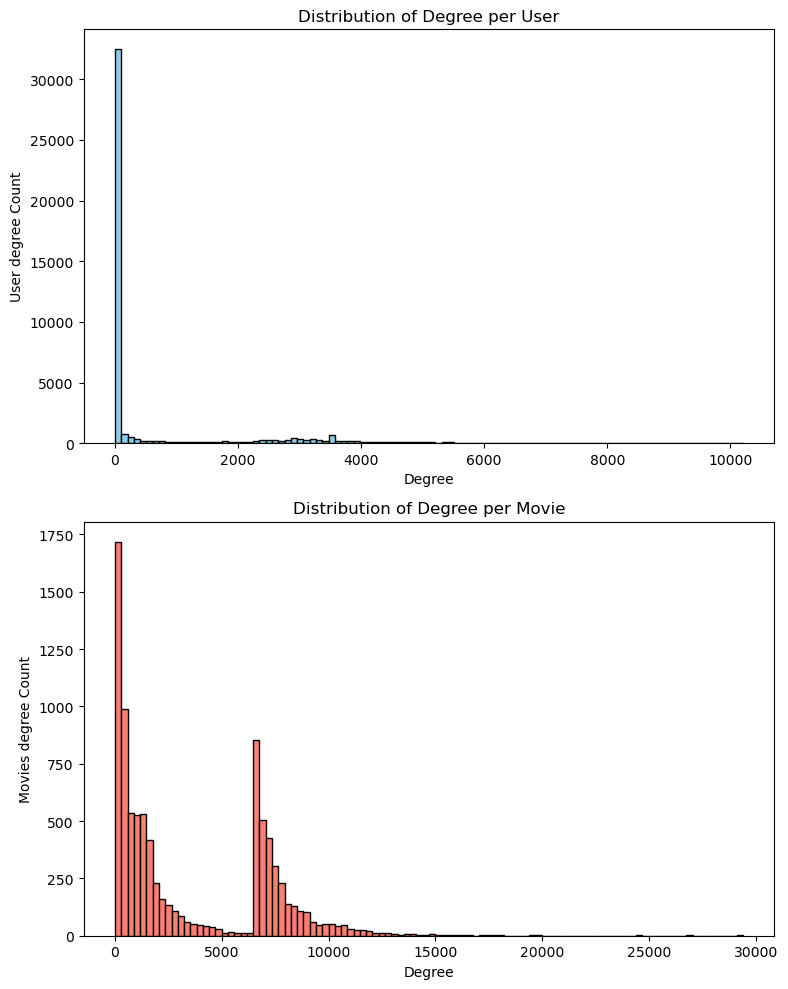

In [24]:
plt.figure(figsize=(8, 10))

# Histogram for user degrees (top)
plt.subplot(2, 1, 1)
plt.hist(user_degrees, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Degree per User')
plt.xlabel('Degree')
plt.ylabel('User degree Count')

# Histogram for movie degrees (bottom)
plt.subplot(2, 1, 2)
plt.hist(movie_degrees, bins=100, color='salmon', edgecolor='black')
plt.title('Distribution of Degree per Movie')
plt.xlabel('Degree')
plt.ylabel('Movies degree Count')

plt.tight_layout()
plt.show()

The largest Weakly Connected Component (WCC) has a size of 51840 nodes which shows that most users and movies are indirectly connected which is good as most nodes are then reachable from one another leading to there always being a recomendation. The graph recomendation algorithm will not error by not being able to find a path but it may fail as the path is very long and will not be a good recomendation. 

The largest Strongly Connected Component (SCC) is much smaller than the WCC whcih indicates a mutual reachablity is limited once direction is respected. This makes sense as influence only can be passed on to those who rate later than them and therefore flows forward in time. This also suggests that influence is highly directional and hierarchial.

In [25]:
# Largest weakly connected component
weakly_components = list(nx.weakly_connected_components(G))
largest_weakly = max(weakly_components, key=len)
print(f"Largest weakly connected component size: {len(largest_weakly)}")

# Largest strongly connected component
strongly_components = list(nx.strongly_connected_components(G))
largest_strongly = max(strongly_components, key=len)
print(f"Largest strongly connected component size: {len(largest_strongly)}")

# Optionally, display which type is larger and a sample of nodes
print(f"Sample nodes in largest weakly connected component: {list(largest_weakly)[:10]}")
print(f"Sample nodes in largest strongly connected component: {list(largest_strongly)[:10]}")

Largest weakly connected component size: 51840
Largest strongly connected component size: 19707
Sample nodes in largest weakly connected component: [131074, 131078.0, 131079.0, 10, 131082, 131083.0, 131097.0, 131100, 28.0, 29.0]
Sample nodes in largest strongly connected component: [131074, 131082, 131100, 29, 37, 131110, 131112, 131114, 43, 262189]


Degree centrality is

$C_D(V) = \frac{\deg(V)}{N - 1}$,

where $N$ is the number of nodes the node could possibly connect to.
This means this is a normalised version of degree and will take into consideration the wider possible connections in the Graph.
The graph constructed has a low average degree centrality of 0.022 to 2SF which could indicate a sparse graph.

The In/Out degree centrality will indicate how influenced/ influencing a User node is for example the user with ID 10 has 0 in degree centrality which indicates no influenciality and in fact will only be influenced by others


In [26]:
# Degree centrality (direction ignored)
deg_cent = nx.degree_centrality(G_reversed)

# In-degree centrality
in_deg_cent = nx.in_degree_centrality(G_reversed)

# Out-degree centrality
out_deg_cent = nx.out_degree_centrality(G_reversed)

print("Degree centrality:", list(deg_cent.items())[:5])
print("In degree centrality:", list(in_deg_cent.items())[:5])
print("Out degree centrality:", list(out_deg_cent.items())[:5])


Degree centrality: [(10, 3.856908687686819e-05), (28, 0.0014077716710056889), (29, 0.06738019477388872), (33, 0.00019284543438434094), (35, 0.0003085526950149455)]
In degree centrality: [(10, 0.0), (28, 0.0), (29, 0.016372577379230546), (33, 0.0), (35, 0.0)]
Out degree centrality: [(10, 3.856908687686819e-05), (28, 0.0014077716710056889), (29, 0.05100761739465818), (33, 0.00019284543438434094), (35, 0.0003085526950149455)]


Betweenness centrality is 

$C_B(v) = \sum_{\substack{s \neq v \neq t}} \frac{\sigma_{st}(v)}{\sigma_{st}}$,

where
$\sigma_{st}$ = number of shortest paths between nodes $s$ and $t$
$\sigma_{st}(v)$​ = number of those paths that pass through $v$.

This is very computationally expensive and unrealistic to run in python on a Graph of this size so it will be downsampled for this and approximated.
Nodes with high betweenness lie on a large number of shortest paths and act as bridges between paths. This would be users who have influenced a large amount of users to watch a large amount of movies. This could also be popular movies rated highly by many users that is also similar to other movies.

In [27]:
# Take top N users by out-degree or influence
top_users = sorted(
    G_reversed.out_degree(weight='distance'),
    key=lambda x: x[1],
    reverse=True
)[:2000]

top_nodes = [u for u, _ in top_users]

G_sub = G_reversed.subgraph(top_nodes).copy()

bc = nx.betweenness_centrality(
    G_sub,
    normalized=True
)

print(list(bc.items())[:5])

[(188419, 2.681486140212544e-06), (114692, 5.6118767587071406e-06), (106503, 3.630264890683813e-06), (114715, 1.7411447280375631e-06), (172063, 3.8551684347741386e-06)]


The Louvain community was chosen as it has a hihg modularity output and scales well with large graphs. This then found 25 communities with a modularity score of 0.644. This is a high score suggesting strong and well defined division of the network. This indicates that there are groups of users who have rated movies and influence each other but stay disconnected to other groups. This supports the idea that there are many pockets of densely connected communities while the large number of communities suggest the overall sparseness that we see in the degree/betweenness centrality.

In [28]:
G_undirected = G_reversed.to_undirected()

In [29]:
# Detect communities using Louvain algorithm
communities = louvain_communities(G, seed=1)

In [30]:
print(f"Number of communities found: {len(communities)}\n")

Number of communities found: 25



In [31]:
# Compute modularity of the partition
Q = modularity(G_undirected, communities)
print(f"Modularity Q: {Q:.3f}")

Modularity Q: 0.644


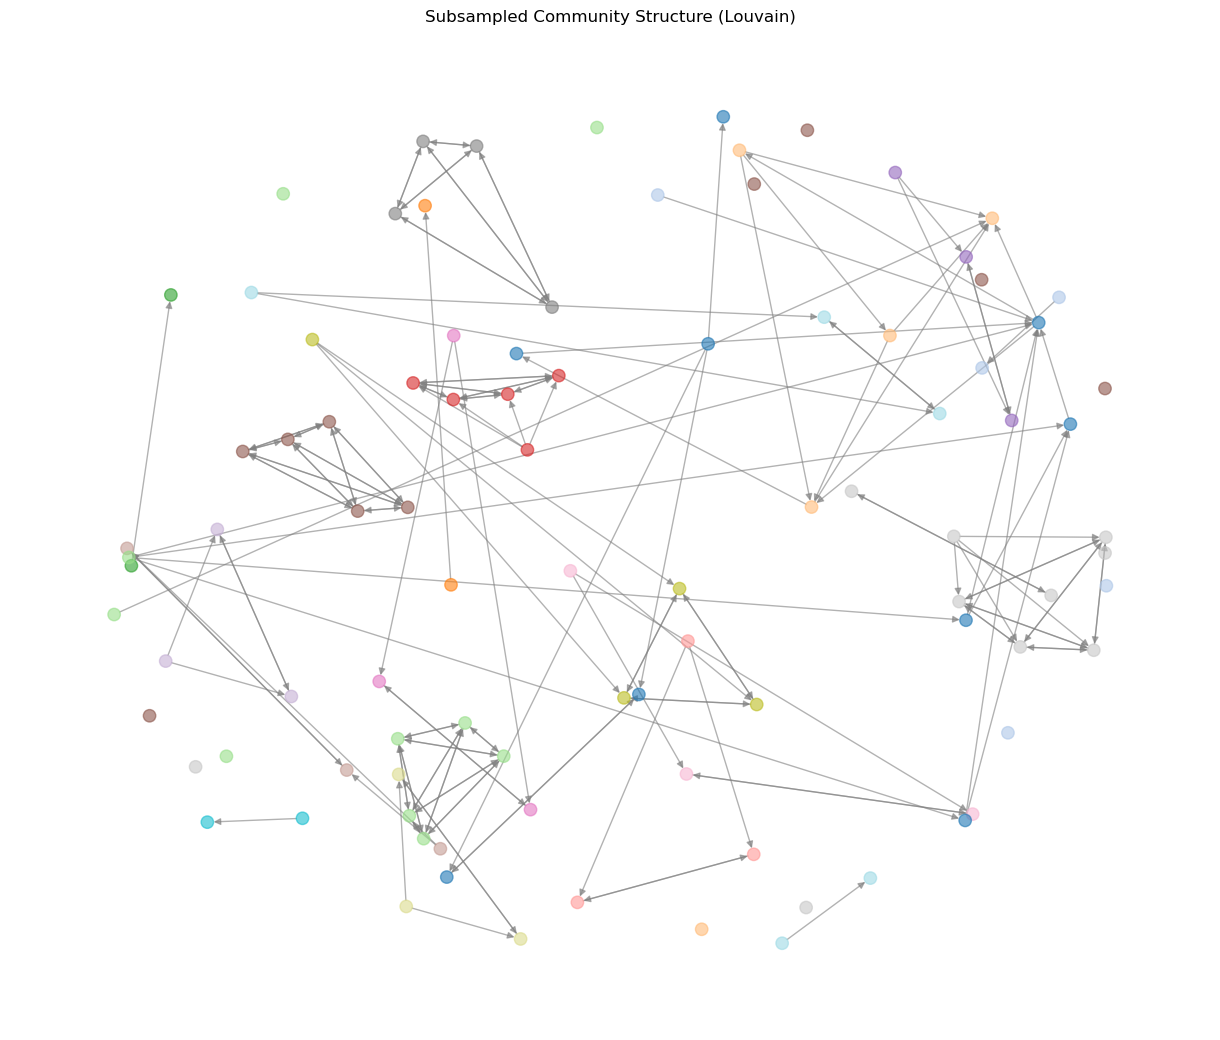

In [53]:
random.seed(1)

MAX_NODES_PER_COMMUNITY = 5 

node_to_comm = {}
for comm_id, nodes in enumerate(communities):
    for n in nodes:
        node_to_comm[n] = comm_id

sampled_nodes = []
for comm, nodes in enumerate(communities):
    nodes = list(nodes)
    sampled_nodes.extend(
        random.sample(nodes, min(len(nodes), MAX_NODES_PER_COMMUNITY))
    )

H = G_reversed.subgraph(sampled_nodes).copy()

node_colors = [node_to_comm[n] for n in H.nodes()]

pos = nx.spring_layout(H, seed=42, k=0.5)

plt.figure(figsize=(12, 10))
nx.draw(
    H,
    pos,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    node_size=80,
    edge_color='gray',
    alpha=0.6,
    with_labels=False
)

plt.title("Subsampled Community Structure (Louvain)")
plt.show()